In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysimtra as ps

#### Import the SIMTRA executable into the package

This needs to be done only ONCE when the package is used the first time. The function copies the SIMTRA executable (and some other files cruical for the execution) into the package folder. Calling this method later again will replace the already existing copied files.

In [2]:
# Define the path to the SIMTRA application folder
sim_path = 'C:/Users/Felix/Desktop/simtra_v2.2'
# Import the application into the package
ps.import_exe(sim_path)

#### Set up a simple single-cathode sputter system programmatically

In [3]:
# Create a cylindrical sputter chamber
ch = ps.Chamber.cylindrical(radius=0.12, length=0.18, temperature=293, pressure=0.5)
# Construct the magnetron with a 2 inch target from a few simple surfaces
target = ps.Circle(name='target', radius=0.0191, position=(0, 0, 0.055))
shield = ps.Cone(name='shield', small_rho=0.0191, big_rho=0.023, height=0.005, position=(0, 0, 0.055))
cap = ps.Circle(name='cap', radius=0.03, position=(0, 0, 0.06))
cap.perforate(by='circle', radius=0.023)
body = ps.Cylinder(name='body', radius=0.03, height=0.06)
# Combine all surfaces into a dummy object 
m_object = ps.DummyObject(name='magnetron', surfaces=[target, shield, cap, body])
# Define a path to the racetrack file
r_path = 'racetracks/Pt_racetrack_1.5_inch.txt'
# Finally construct the magnetron
mag = ps.Magnetron(transported_element='Pt', 
                   m_object=m_object, 
                   n_particles=10**8, 
                   sputter_surface_index=1,  # the first surface is the target
                   racetrack_file_path=r_path,
                   max_ion_energy=200)
# Define the size of the substrate (this is reused later when plotting the results)
s_dx, s_dy = 0.05, 0.05
# Create a rectangle to track the particles arrival
s_surf = ps.Rectangle(name='subSurface', dx=s_dx, dy=s_dy, save_avg_data=True, avg_grid=(200, 100))
# Wrap the rectangle into a dummy object
sub = ps.DummyObject(name='substrate', surfaces=[s_surf], position=(0, 0, 0.15))
# Define an output path for the simulation
out_path = 'C:/Users/Felix/Desktop/sim_result'
# Combine chamber, magnetron and substrate into a sputter system
system = ps.SputterSystem(ch, mag, sub, out_path)

After creation of the system, it can be written to a ".sin" file e.g. to view it in the GUI version of SIMTRA:

In [4]:
# Save the Sputter System as a sin file
system.to_sin(path='C:/Users/Felix/Desktop/res.sin')

Perform the simulation. This part only works on Windows operating systems.

In [5]:
# Start the simulation
result = system.simulate()

Plot the results:

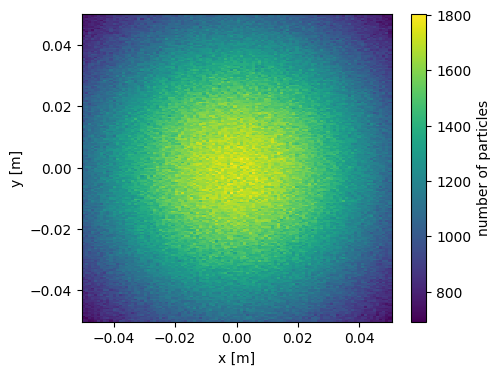

In [6]:
# Get the number of particles sputtered onto the substrate
n_p = result.n_particles['substrate']
# Create a meshgrid for also displaying x and y values
x = np.linspace(-s_dx, s_dx, n_p.shape[1])
y = np.linspace(-s_dx, s_dx, n_p.shape[0])
X, Y = np.meshgrid(x, y)

# Plot the particle distribution as a 2D image
fig, ax = plt.subplots(figsize=(5, 4))
pc = ax.pcolormesh(X, Y, n_p)
# Add axes labels
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
# Add a colorbar
fig.colorbar(pc, ax=ax, label='number of particles')
plt.show()

#### Set up a multi-cathode system programmatically

In [2]:
# Create a cylindrical sputter chamber
ch = ps.Chamber.cylindrical(radius=0.12, length=0.18, temperature=293, pressure=0.5)
# Construct the magnetron will be identical to the example of the single-cathode system
target = ps.Circle(name='target', radius=0.0191, position=(0, 0, 0.055))
shield = ps.Cone(name='shield', small_rho=0.0191, big_rho=0.023, height=0.005, position=(0, 0, 0.055))
cap = ps.Circle(name='cap', radius=0.03, position=(0, 0, 0.06))
cap.perforate(by='circle', radius=0.023)
body = ps.Cylinder(name='body', radius=0.03, height=0.06)
# Define the elements and ion energies to use (depends on the power supply)
e_ion = {'Ni': 54, 'Ru': 262, 'Pt': 305, 'Pd': 270}
# The chamber will have four cathodes positioned on an "anker circle" and with an identical tilt
cat_pos = {'Ni': 45, 'Ru': 135, 'Pt': -135, 'Pd': -45}  # °
r_anker, cat_tilt = 0.06, 10  # m, °
# Create a magnetron for each element
mags: list[ps.Magnetron] = []
for i, elem in enumerate(e_ion.keys(), 1):
    # Calculate the position (in m) and orientation (in °)
    pos = np.cos(np.radians(cat_pos[elem])) * r_anker, np.sin(np.radians(cat_pos[elem])) * r_anker, 0
    orien = cat_pos[elem], -cat_tilt, 0
    # Create the dummy object from the surfaces
    m_object = ps.DummyObject(name='mag_%d' % i, surfaces=[target, shield, cap, body], position=pos, orientation=orien)
    # Define a path to the racetrack file
    r_path = 'racetracks/%s_racetrack_1.5_inch.txt' % elem
    # Construct the magnetron
    mag = ps.Magnetron(transported_element=elem, m_object=m_object, n_particles=10**8, 
                       sputter_surface_index=1, racetrack_file_path=r_path, max_ion_energy=e_ion[elem])
    # Store the new magnetron to assign it later to the sputter system
    mags.append(mag)
# Define the size of the substrate (this is reused later when plotting the results)
s_dx, s_dy = 0.05, 0.05
# Create a rectangle to track the particles arrival
s_surf = ps.Rectangle(name='subSurface', dx=s_dx, dy=s_dy, save_avg_data=True, avg_grid=(200, 100))
# Wrap the rectangle into a dummy object
sub = ps.DummyObject(name='substrate', surfaces=[s_surf], position=(0, 0, 0.15))
# Define an output path for the simulation
out_path = 'C:/Users/Felix/Desktop/sim_result'
# Creating the sputter system is identical to a single-cathode system, just pass a list of magnetrons rather than a single one
system = ps.SputterSystem(ch, mags, sub, out_path)

Also a sputter system with multiple magnetrons can be exported, but this needs to be done to multiple ".sin" files since a single file can only hold one magnetron. When doing that, the remaining magnetrons are automatically converted to dummy objects, so they are still considered in the simulation.

In [26]:
# Save sputter system with the first magnetron as a sin file. In the cell above we defined the first magnetron as "mag_1", therefore this name needs to 
# be used
system.to_sin(path='C:/Users/Felix/Desktop/res.sin', mag_name='mag_1')

Perform the simulation of all magnetrons at the same time. This is powered by multithreading and depending on the number of cores of your CPU, the simulations are run in parallel. 

In [3]:
# Start the simulation
results = system.simulate()
# Alternatively, by passing a list to the optional parameter "magnetrons", a subset of magnetrons can be simulated, e.g.
# results = system.simulate(magnetrons=['mag_2', 'mag_4'])

Plotting the results is also very similar to the single-magnetron system. There will be one SimtraOutput object per magnetron. The order is identical to the order of the list provided when the SputterSystem object was created. When the "magnetrons" paramater was used when the simulation was started, the order of outputs corresponds to the order of magnetron names passed to this parameter. 

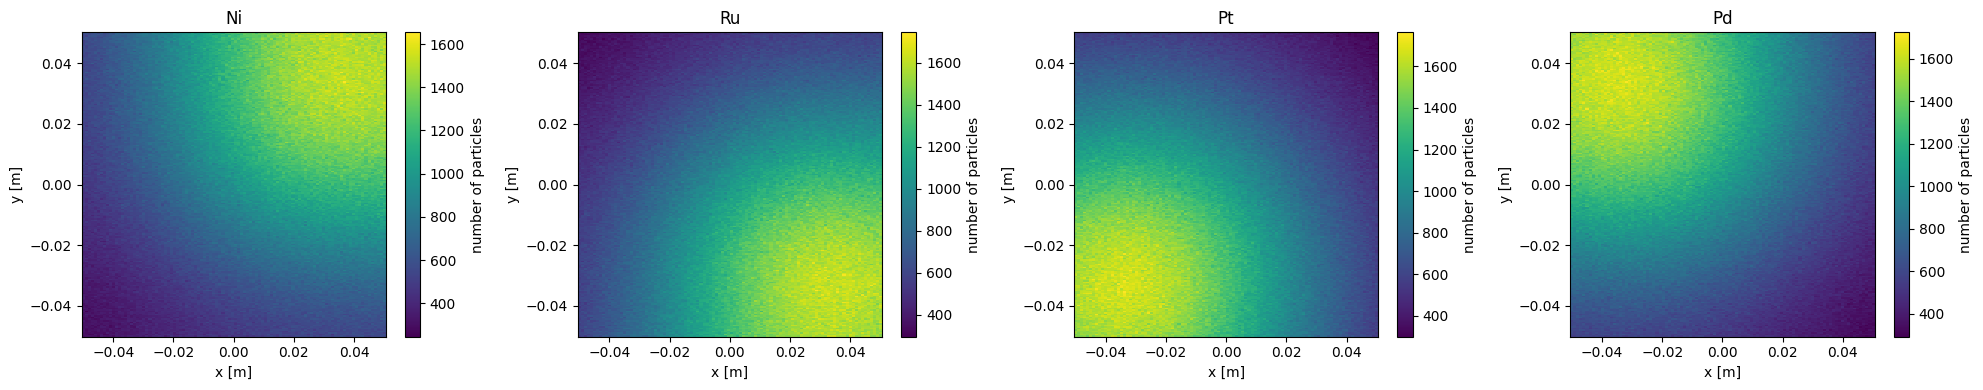

In [29]:
# Create a plot with as many subplots as there are outputs
fig, ax = plt.subplots(1, len(results), figsize=(len(results) * 5, 4))

# Iterate over the elements and load plot simulation result
for i, elem in enumerate(e_ion.keys()):
    # Get the number of particles sputtered onto the substrate identical to the single-magnetron system
    n_p = results[i].n_particles['substrate']
    # Create a meshgrid for also displaying x and y values (also identical)
    x = np.linspace(-s_dx, s_dx, n_p.shape[1])
    y = np.linspace(-s_dx, s_dx, n_p.shape[0])
    X, Y = np.meshgrid(x, y)
    # Plot the particle distribution
    pc = ax[i].pcolormesh(X, Y, n_p)
    # Add axes labels
    ax[i].set_xlabel('x [m]')
    ax[i].set_ylabel('y [m]')
    # Add a title showing the sputtered elements
    ax[i].set_title(elem)
    # Add a colorbar
    fig.colorbar(pc, ax=ax[i], label='number of particles')

# Adjust layout and show the plot
fig.tight_layout()
plt.show()